# 📚 LangGraph Learning - Iterative Tweet Generator Practice

This is my **practice notebook** while learning **LangGraph** for building iterative agentic AI workflows. Not a production project — just hands-on experimentation with **feedback loops**! 🧪

## 🎯 What I'm Learning

- How to build **iterative/looping workflows** with LangGraph
- Using **multiple LLMs** for different tasks (Generator, Evaluator, Optimizer)
- **Conditional routing** with feedback loops
- **Structured outputs** for evaluation criteria
- **State accumulation** with `Annotated` and `operator.add`
- Setting **iteration limits** to prevent infinite loops

## 🧠 Concepts Practiced

| Concept | What I Learned |
|---------|----------------|
| `StateGraph` | Managing complex state across multiple iterations |
| `Annotated[list, operator.add]` | Accumulating history across loop iterations |
| `add_conditional_edges()` | Creating loops that can exit based on conditions |
| `with_structured_output()` | Getting consistent evaluation results from LLM |
| Multi-LLM Architecture | Using different models for different tasks |
| Iteration Control | Preventing infinite loops with `max_iteration` |

## 🔬 What This Practice Code Does

An iterative tweet generator that:

```
Generate Tweet → Evaluate → (If not approved) → Optimize → Re-evaluate → Loop...
```

- **Generator LLM** → Creates initial tweet
- **Evaluator LLM** → Ruthlessly critiques the tweet
- **Optimizer LLM** → Improves based on feedback
- **Loop** until approved OR max iterations reached

## 🏗️ Graph Flow I Built

```
        START
          │
          ▼
    ┌───────────┐
    │ generate  │  ← Creates initial tweet
    └─────┬─────┘
          │
          ▼
    ┌───────────┐
    │ evaluate  │◄─────────────┐
    └─────┬─────┘              │
          │                    │
     ┌────┴────┐               │
     │ Router  │               │
     └────┬────┘               │
          │                    │
    ┌─────┴─────┐              │
    │           │              │
    ▼           ▼              │
Approved    Needs Work         │
    │           │              │
    ▼           ▼              │
   END    ┌───────────┐        │
          │ optimize  │────────┘
          └───────────┘
              ▲
              │
        (Loop back)
```

## 🤖 Multi-LLM Architecture

| Role | Model | Purpose |
|------|-------|---------|
| **Generator** | `openai/gpt-oss-20b` | Creates initial tweet |
| **Evaluator** | `moonshotai/kimi-k2-instruct` | Critiques with structured output |
| **Optimizer** | `openai/gpt-oss-120b` | Improves based on feedback |

## 🛠️ Setup

```bash
# Install dependencies
pip install langgraph langchain-groq langchain-core pydantic python-dotenv

# Create .env file
echo "GROQ_API_KEY=your_key_here" > .env
```

## 📝 Key Code Snippets I Practiced

### 1. State with History Accumulation
```python
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    
    # These accumulate across iterations!
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]
```

### 2. Structured Output for Evaluation
```python
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str

structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)
```

### 3. Conditional Routing with Exit Condition
```python
def route_evaluation(state: TweetState):
    # Exit if approved OR max iterations reached
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'
```

### 4. Building the Iterative Graph
```python
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', route_evaluation, {
    'approved': END, 
    'needs_improvement': 'optimize'
})
graph.add_edge('optimize', 'evaluate')  # Loop back!

workflow = graph.compile()
```

### 5. Running with Initial State
```python
initial_state = {
    "topic": "math",
    "iteration": 0,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

# View all tweet versions
for tweet in result['tweet_history']:
    print("..", tweet)
```

## 📊 Evaluation Criteria Used

### Section 1: Auto-Reject Rules
- ❌ Exceeds 280 characters
- ❌ Question-answer format
- ❌ Traditional joke structure
- ❌ Weak/generic conclusion

### Section 2: Qualitative Metrics (1-5 scale)
| Metric | What It Measures |
|--------|------------------|
| **Originality** | Fresh, non-cliché perspective |
| **Humor & Tone** | Sharp, observational wit |
| **Impact & Density** | Every character earns its place |
| **Shareability** | Would people retweet this? |

### Approval Threshold
✅ **Approved**: Passes Section 1 AND scores ≥4 in at least 3 metrics

## 📖 Resources I Used

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangGraph Cycles & Loops](https://langchain-ai.github.io/langgraph/concepts/low_level/#cycles)
- [Pydantic Structured Outputs](https://python.langchain.com/docs/concepts/structured_outputs/)

## 🚧 Next Steps

- [ ] Add human-in-the-loop approval option
- [ ] Visualize improvement across iterations
- [ ] Add more evaluation dimensions
- [ ] Try different model combinations
- [ ] Add persistence to resume workflows

## 💡 Notes to Self

- `Annotated[list, operator.add]` is key for accumulating history
- Always set `max_iteration` to prevent infinite loops
- Different LLMs have different strengths — mixing them works well!
- Error handling in `evaluate_tweet` prevents crashes on structured output failures
- The loop pattern: `Node A → Node B → conditional → back to Node A`

## ⚠️ Gotchas I Encountered

1. **Iteration starts at 0** — not 1, to get accurate count
2. **History lists need initialization** — but LangGraph handles empty lists
3. **Structured output can fail** — always add try/except fallback

---

*This is part of my Agentic AI learning journey — practicing iterative workflows! 🚀*

In [42]:
from langgraph.graph import START,END,StateGraph
from langchain_groq import ChatGroq
from dotenv import load_dotenv 
from typing import TypedDict,Literal,Annotated
import operator
from langchain_core.messages import HumanMessage,SystemMessage
from pydantic import BaseModel,Field
load_dotenv()
model=ChatGroq(model="openai/gpt-oss-20b")


In [43]:

generator_llm =ChatGroq(model="openai/gpt-oss-20b")
evaluator_llm =ChatGroq(model="moonshotai/kimi-k2-instruct-0905")
optimizer_llm =ChatGroq(model="openai/gpt-oss-120b")

In [44]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [45]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [46]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [47]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a professional  and brilliant Twitter/X influencer."),
        HumanMessage(content=f"""
Generate a concise, shareable tweet about {state['topic']} designed to achieve high engagement (likes, retweets) from a professional, social-media-savvy audience.

Core Requirements:

Character Limit: Strictly 280 characters or less. Every character must earn its place.
Format Directive: Do not use a question-answer or open-ended question format. The tweet must be a definitive, clever observation.
Creative Specifications:

Tone & Humor: Employ sharp, observational humor, refined irony, or intelligent sarcasm. The goal is to elicit a wry smile of recognition, not a loud laugh. Avoid puns, dad jokes, or overt silliness.
Voice & Style: Use relatable, contemporary, everyday language, but polished. The rhythm and payoff should feel akin to a successful meme or a perfect one-liner—highly punchy and immediately gratifying.
Core Mechanism: Frame a universal, often unspoken, truth about {state['topic']}. The tweet should feel like a "truth bomb" or a brilliantly framed observation that makes the reader think, "Yes, exactly."
Audience Value: The tweet must provide value by either:

A.) Articulating a shared professional frustration with clever clarity.
B.) Revealing an ironic contradiction inherent in the topic.
C.) Reframing a mundane aspect of the topic in a brilliantly simple, new light.
Final Quality Check: The output should be self-contained, witty, and feel inherently "shareable." A reader should want to retweet it to their own network to signal their own insight, taste, or affiliation with the observation.
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [49]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="""You are a ruthless Twitter critic. You evaluate tweets.
You MUST use the provided function/tool to respond. Do NOT respond with plain text or markdown."""),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Objective: Conduct a ruthless, structured audit of a generated tweet against explicit virality criteria. Determine whether it meets the standards for professional social media engagement or requires rejection/refinement.

AUDIT CRITERIA

SECTION 1: MANDATORY COMPLIANCE (AUTO-REJECT)
The tweet must be rejected immediately if it violates ANY of these:

Length Violation: Exceeds 280 characters.
Forbidden Format: Is written in a question-answer or open-ended question format.
Joke Structure: Follows a traditional setup-punchline joke architecture.
Weak Conclusion: Ends with a generic summary, explanatory tagline, or deflating phrase that dilutes the impact.
SECTION 2: QUALITATIVE VIRALITY METRICS
If it passes Section 1, evaluate on these scales:

Originality & Insight (1-5): Does it offer a fresh, non-cliché perspective? Does it frame a universal or unspoken truth?
Humor & Tone (1-5): Does it use sharp, observational humor, refined irony, or intelligent sarcasm that elicits a "wry smile"? Avoids puns/dad jokes.
Impact & Density (1-5): Is every character necessary? Does it have the punchy, immediate gratification of a successful meme or one-liner?
Shareability Quotient (1-5): Does it provide clear audience value (A, B, or C from spec)? Would retweeting it signal the sharer's insight, taste, or affiliation?
Scoring Key:

5: Exemplary - Perfectly embodies the criterion
4: Strong - Minor room for improvement
3: Adequate - Meets basic requirements
2: Weak - Significant shortcomings
1: Poor - Fails the criterion
SECTION 3: OVERALL THRESHOLD

APPROVE: Passes Section 1 AND scores ≥4 in at least 3 of the 4 qualitative metrics.
NEEDS IMPROVEMENT: Passes Section 1 but fails to meet the qualitative threshold.
REJECT: Fails any criterion in Section 1.

Use the TweetEvaluation function to provide your response with:
- evaluation: either "approved" or "needs_improvement"
- feedback: one paragraph explaining strengths and weaknesses
""")
]

    try:
        response = structured_evaluator_llm.invoke(messages)
        return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}
    except Exception as e:
        # Fallback: if structured output fails, default to needs_improvement
        return {'evaluation': 'needs_improvement', 'feedback': f'Evaluation failed, retrying optimization. Error: {str(e)}', 'feedback_history': [f'Evaluation failed: {str(e)}']}

In [50]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You are a expert social media copywriter on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [51]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

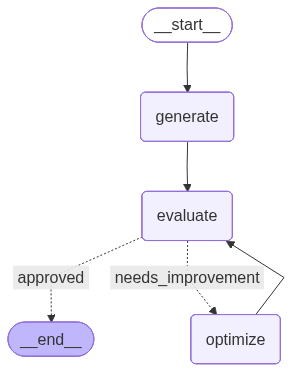

In [52]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [57]:
initial_state = {
    "topic": "math",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [58]:
result

{'topic': 'math',
 'tweet': 'A stray cat paw erased a line, and the missing curve completed the proof. Turns out the theorem was hiding in chaos, not caffeine. 🐾📐 #CatProof #MathSerendipity',
 'evaluation': 'needs_improvement',
 'feedback': 'The tweet passes all Section 1 checks, delivering a compact 139-character vignette that avoids question formats and setup-punchline beats while ending on a punchy hashtag. Its central metaphor—a cat’s paw completing a mathematical proof—lands as a fresh, whimsical marriage of math-geek culture and pet love, nailing Originality & Insight (5). The humor is subtle, almost mystical, but a bit too soft to trigger the wry smile we target; it lacks a sharper ironic twist, so Humor & Tone merits a 3. Every word earns its place, yet the payoff (“the theorem was hiding in chaos, not caffeine”) feels abstract rather than meme-immediate, which caps Impact & Density at 3.5 (rounded to 3). Shareability is decent—retweeting signals math/science affinity plus cat 

In [59]:
for tweet in result['tweet_history']:
    print("..",tweet)

.. Math is the only profession where you can solve a problem, proudly present a perfect graph, and still realize the assumptions were just a wild guess. #TruthBomb
.. We spend weeks polishing a perfect graph, then discover the whole theorem rests on a guess you scribbled at 3 am. Welcome to math—turning wild assumptions into “proofs.” #MathMischief
.. After weeks of polishing the perfect graph, we realize the whole theorem rides on that 3 am doodle. That’s math: turning midnight scribbles into peer‑reviewed proof. #MidnightMath
.. Weeks of polishing a “perfect” graph, only to realize the theorem’s key was the 3 am doodle of a coffee‑stained napkin. Proof: insomnia + crayon = peer‑reviewed brilliance. #MidnightMath #ProofByCaffeine
.. A stray cat paw erased a line, and the missing curve completed the proof. Turns out the theorem was hiding in chaos, not caffeine. 🐾📐 #CatProof #MathSerendipity
